In [123]:
!pip install vaderSentiment


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import re
import emoji
from pathlib import Path 



In [125]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
df=pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')

In [127]:
df.head(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [128]:
df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

### Keep only useful columns & clean timestamps

In [129]:
df=df[['tweet_id','airline_sentiment','text','tweet_created']]

In [130]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'text', 'tweet_created'], dtype='object')

In [131]:
df.rename(columns={'airline_sentiment': 'label'}, inplace=True)

In [132]:
df['tweet_created']

0        2015-02-24 11:35:52 -0800
1        2015-02-24 11:15:59 -0800
2        2015-02-24 11:15:48 -0800
3        2015-02-24 11:15:36 -0800
4        2015-02-24 11:14:45 -0800
                   ...            
14635    2015-02-22 12:01:01 -0800
14636    2015-02-22 11:59:46 -0800
14637    2015-02-22 11:59:15 -0800
14638    2015-02-22 11:59:02 -0800
14639    2015-02-22 11:58:51 -0800
Name: tweet_created, Length: 14640, dtype: object

In [133]:
df['tweet_created']=pd.to_datetime(df['tweet_created'],errors='coerce',utc=True)

In [134]:
df.isnull().sum()/df.shape[0]

tweet_id         0.0
label            0.0
text             0.0
tweet_created    0.0
dtype: float64

In [135]:
df.head()

,tweet_id,label,text,tweet_created
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.,2015-02-24 19:35:52+00:00
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...,2015-02-24 19:15:59+00:00
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 19:15:48+00:00
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...,2015-02-24 19:15:36+00:00
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...,2015-02-24 19:14:45+00:00


In [136]:
df.dtypes

tweet_id                       int64
label                         object
text                          object
tweet_created    datetime64[ns, UTC]
dtype: object

### text cleaning

In [137]:
url_pattern=re.compile(r'(https?://\S+|www\.\S+)')
mention_pattern=re.compile(r'@\w+')
hashtag_pattern=re.compile(r'#')
nonalpha_pattern=re.compile(r'[^a-zA-Z\s]')
multispace_pattern = re.compile(r'\s+')

In [138]:
stop_words=set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()


In [139]:
def clean_text(text):
    text=str(text).lower()
    text=emoji.replace_emoji(text,replace='')
    text=url_pattern.sub('',text)
    text=mention_pattern.sub('',text)
    text=hashtag_pattern.sub('',text)
    text=nonalpha_pattern.sub('',text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return multispace_pattern.sub(' ', ' '.join(tokens)).strip()

In [140]:
df['clean_text'] = df['text'].apply(clean_text)

### Sentiment Scoring 

In [141]:
analyzer=SentimentIntensityAnalyzer()

In [142]:
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']
df['sentiment_score']=df['clean_text'].apply(get_sentiment_score)

In [143]:
df['sentiment_label']=np.where(df['sentiment_score']>0.05,'Positive',
                      np.where(df['sentiment_score']<-0.05,'Negative','Neutral'))

In [144]:
df.head()

,tweet_id,label,text,tweet_created,clean_text,sentiment_score,sentiment_label
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.,2015-02-24 19:35:52+00:00,said,0.0000,Neutral
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...,2015-02-24 19:15:59+00:00,plus youve added commercial experience tacky,0.0000,Neutral
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 19:15:48+00:00,didnt today must mean need take another trip,0.0000,Neutral
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...,2015-02-24 19:15:36+00:00,really aggressive blast obnoxious entertainmen...,-0.3306,Negative
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...,2015-02-24 19:14:45+00:00,really big bad thing,-0.5829,Negative


In [145]:
sentiment_count=df['sentiment_label'].value_counts().reindex(['Positive','Neutral','Negative',],
                                                            fill_value=0)


In [146]:
sentiment_count

sentiment_label
Positive    6392
Neutral     3693
Negative    4555
Name: count, dtype: int64

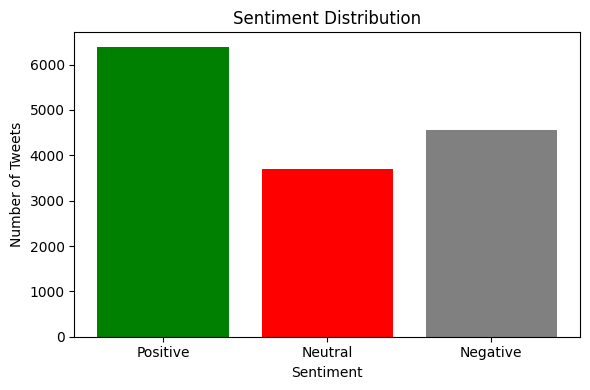

In [147]:
plt.figure(figsize=(6,4))
plt.bar(sentiment_count.index,sentiment_count.values,
       color=['green','red','gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

### Sentiment Trend Over Time

In [148]:
df.columns

Index(['tweet_id', 'label', 'text', 'tweet_created', 'clean_text',
       'sentiment_score', 'sentiment_label'],
      dtype='object')

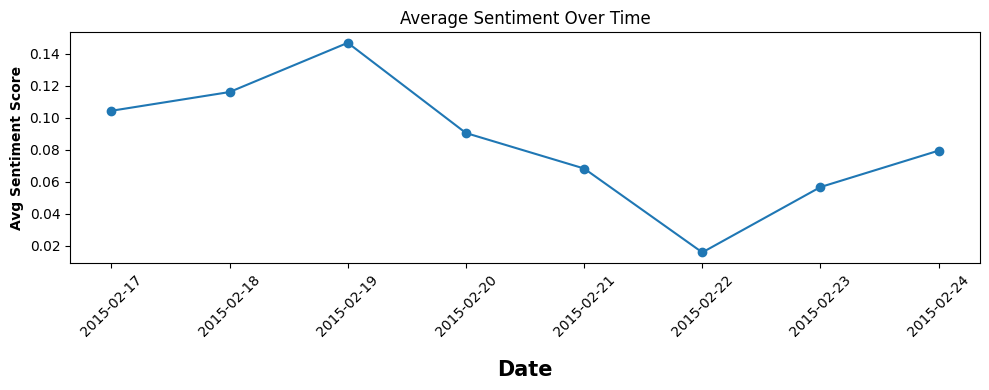

In [149]:
daily_sentiment=df.set_index('tweet_created').resample('D')['sentiment_score'].mean().dropna()
plt.figure(figsize=(10,4))
plt.plot(daily_sentiment.index,daily_sentiment.values,marker='o')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date',fontweight='bold',labelpad=15,size=15)
plt.xticks(rotation=45)
plt.ylabel('Avg Sentiment Score',fontweight='bold',size=10)
plt.tight_layout()
plt.show()

### Word Clouds for Positive and Negative Tweets

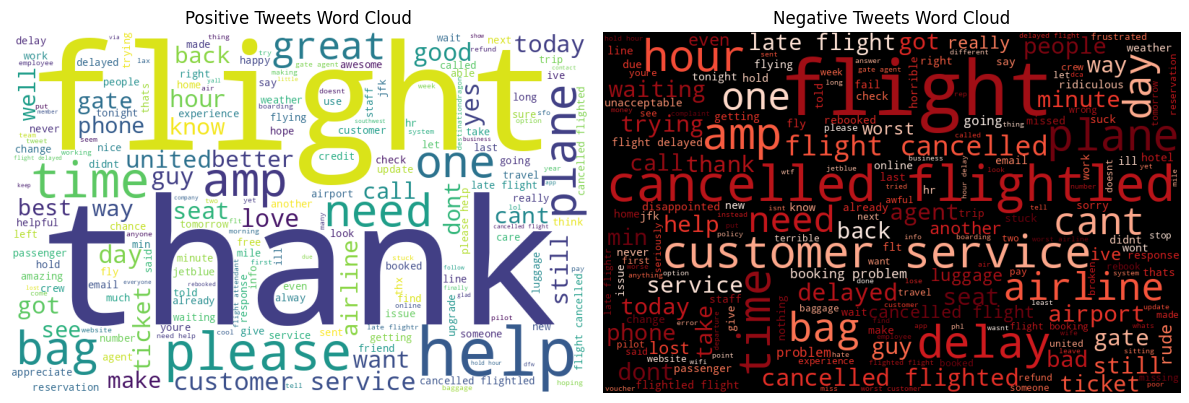

In [150]:
positive_text = ' '.join(df[df['sentiment_label'] == 'Positive']['clean_text'])
negative_text = ' '.join(df[df['sentiment_label'] == 'Negative']['clean_text'])
wordcloud_pos = WordCloud(width=800, height=500, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=500, background_color='black', colormap='Reds').generate(negative_text)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.title("Positive Tweets Word Cloud")
plt.subplot(1,2,2)
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.title("Negative Tweets Word Cloud")
plt.tight_layout()